In [1]:
# Module für Einlesen der Textdatei / Umwandeln in DataFrame
import pandas as pd
import numpy as np
import requests
import itertools
import math
import configparser

In [2]:
config = configparser.ConfigParser()
config.read('../config.ini')

vg_json = config['PATHS']['vg-json']
vg_json_export = config['PATHS']['json-export']
image_dir = config['PATHS']['vg-images']

data_dir = vg_json_export + 'vandeweijer2007/ColorNaming/'

In [3]:
# Module für Visualisierung
import sys
import os

sys.path.append(os.path.abspath('../Module'))
import visualize

## Text einlesen, in DataFrame umwandeln

In [4]:
# Textdatei abrufen
r = requests.get('http://www.cvc.uab.es/color_naming/MembershipValues_sRGB.txt')
# Text einlesen
data = r.text
# Zeilen trennen
data = data.split('\r\n')
# letzte Zeile ist leer
data = data[:-1]

# DataFrame erstellen mit Columns aus Text-Datei
# vgl. http://www.cvc.uab.es/color_naming/
columns = 'r g b red orange brown yellow green blue purple pink white grey black'.split()
df = pd.DataFrame(columns=columns) 

# Zeile für Zeile zu DataFrame hinzufügen
for line in data:
    s = pd.Series(line.split('\t'), index = columns) 
    df = df.append(s,ignore_index=True)

# Type der Einträge von str zu float64
df = df.astype('float64')

In [5]:
df.head()

r      g      b   red  orange  brown  yellow  green  blue  purple  \
0  163.0   74.0   86.0  6.70    0.00   3.00     0.0    0.0   0.0    0.20   
1  202.0   80.0   91.0  9.25    0.05   0.35     0.0    0.0   0.0    0.05   
2  217.0   83.0  112.0  2.75    0.00   0.00     0.0    0.0   0.0    0.25   
3  226.0  119.0  134.0  2.55    0.00   0.00     0.0    0.0   0.0    0.00   
4  230.0  173.0  170.0  1.10    0.25   0.65     0.0    0.0   0.0    0.00   

   pink  white  grey  black  
0  0.10    0.0   0.0    0.0  
1  0.30    0.0   0.0    0.0  
2  7.00    0.0   0.0    0.0  
3  7.45    0.0   0.0    0.0  
4  8.00    0.0   0.0    0.0

## Visualisierung

In [52]:
# Per Idxmax: Color Term mit höchstem Wert pro Eintrag
max_val = df[columns[3:]].idxmax(axis=1).rename('color')
df_max = df[columns].merge(max_val, left_index=True, right_index=True)

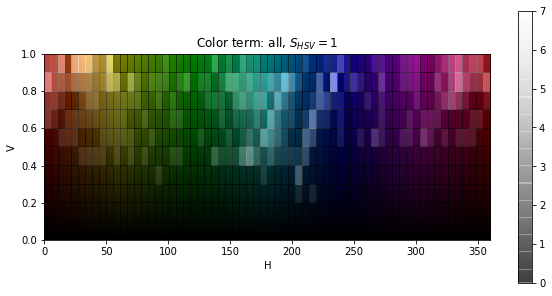

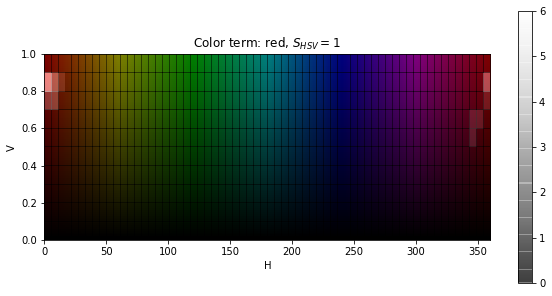

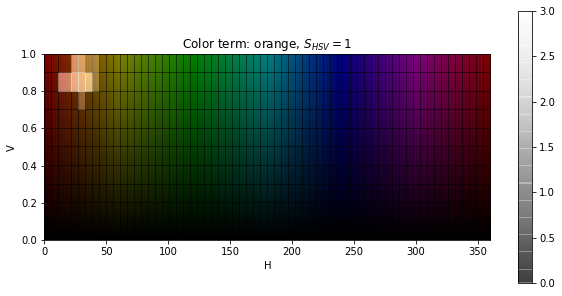

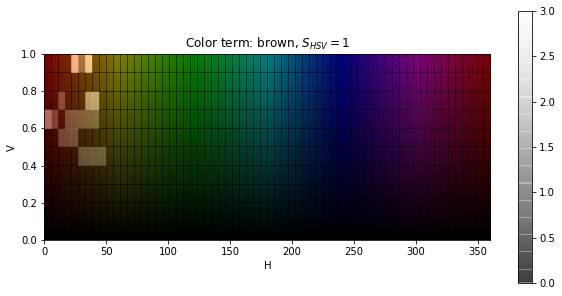

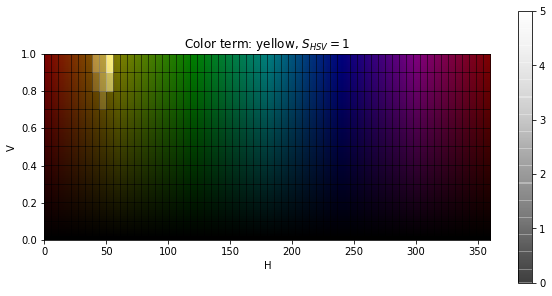

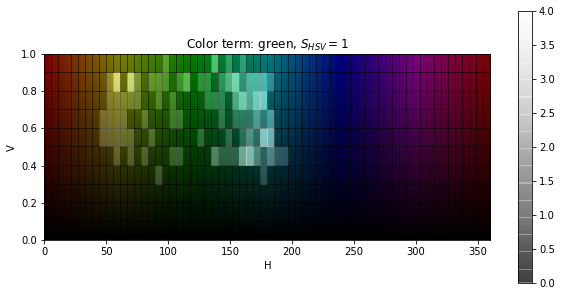

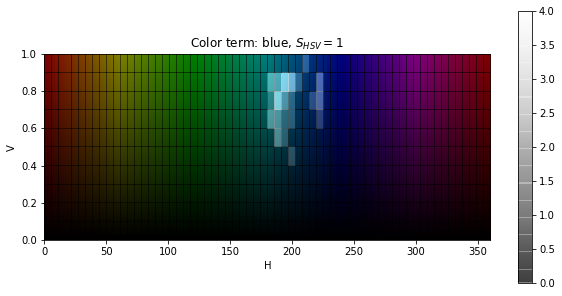

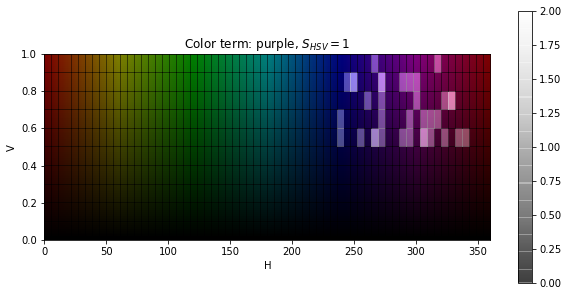

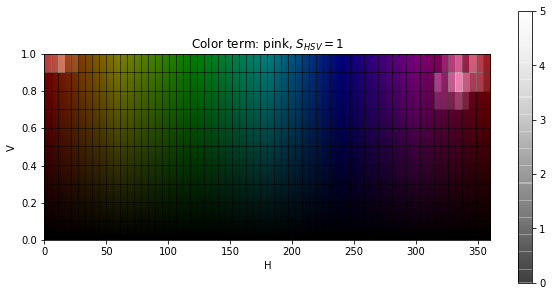

In [53]:
# in HSV-Farbraum plotten
df_max['rgb'] = df_max.apply(lambda x:[x.R,x.G,x.B], axis=1)

# alle Farben
visualize.plot_in_hsv_chart(df_max.rgb.values, color_term = 'all',figsize=(10,5),xbins=64,ybins=10)

# einzelne Farben
for color in columns[3:-3]:
    visualize.plot_in_hsv_chart(df_max.loc[df_max['color']==color].rgb.values, color_term = color,figsize=(10,5),xbins=64,ybins=10)

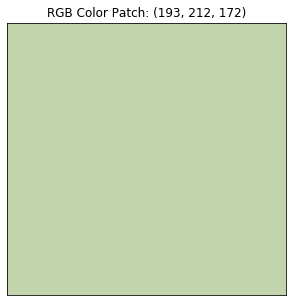

green 

membership values:
red          0
orange       0
brown        0
yellow    0.35
green      9.6
blue         0
purple       0
pink         0
white     0.05
grey         0
black        0
Name: 121, dtype: object





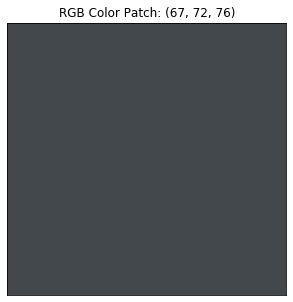

black 

membership values:
red          0
orange       0
brown        0
yellow       0
green     0.05
blue         0
purple       0
pink         0
white        0
grey         0
black     9.95
Name: 372, dtype: object





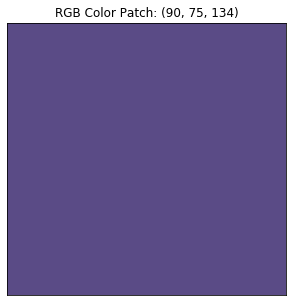

purple 

membership values:
red         0
orange      0
brown       0
yellow      0
green       0
blue      0.7
purple    9.3
pink        0
white       0
grey        0
black       0
Name: 241, dtype: object





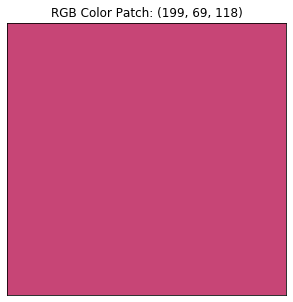

pink 

membership values:
red       0.55
orange       0
brown        0
yellow       0
green        0
blue         0
purple     0.9
pink      8.55
white        0
grey         0
black        0
Name: 323, dtype: object





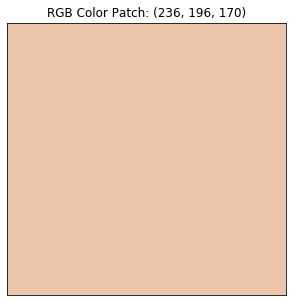

pink 

membership values:
red         0
orange      3
brown     1.7
yellow    0.1
green       0
blue        0
purple      0
pink        5
white     0.2
grey        0
black       0
Name: 34, dtype: object





121    None
372    None
241    None
323    None
34     None
dtype: object

In [55]:
# Farbsamples plotten

def plot_rgb(entry):
    rgb = entry['rgb']
    label = entry['color']
    visualize.plot_rgb_color(rgb)
    print (label, '\n')
    print ('membership values:')
    print (entry[columns[3:]])
    print ('\n\n')

df_max.sample(5).apply(lambda x:plot_rgb(x), axis=1)

## Algorithmus zum übertragen auf 32x32x32-Bins (vgl. Van de Weijer 2007)

In [6]:
# geordnete Liste mit RGB-Bins initialisieren
l = []
n = 3.5
for i in range(32):
    l.append(n)
    n += 8
rgb_bins = list(itertools.product(l,l,l))
rgb_bins = sorted(rgb_bins, key = lambda x: (x[2], x[1], x[0]))

In [7]:
def gauss(x, mu=0.0, sigma=1.0):
    """
    Return the value of the Gaussian probability function with mean mu
    and standard deviation sigma at the given x value.
    """
    # aus https://introcs.cs.princeton.edu/python/22module/gaussian.py.html
    x = float(x - mu) / sigma
    return math.exp(-x*x/2.0) / math.sqrt(2.0*math.pi) / sigma

In [8]:
chip_w2c = np.empty((0, 14))
# über RGB-Bins iterieren
for rgb_i in rgb_bins:
    # über RGB-Werte und Wahrscheinlichkeitsverteilungen (Chips) iterieren
    
    # np-Array für Wahrscheinlichkeitsverteilung über Farbnamen initialisieren
    p_i = np.zeros(11)
    
    for j in df.to_numpy():
        # j-Array: RGB-Werte von Wahrscheinlichkeitswerten trennen
        rgb_j = j[:3]
        p_j = j[3:]
        # Euklidische Distanz zwischen RGB-Werten von i und j
        distance = np.linalg.norm(rgb_i-rgb_j)
        p_j = p_j * gauss(distance, sigma=5)
        #p_j = p_j / len(df.to_numpy())
        p_i += p_j
    p_i = p_i / p_i.sum()
    i = np.append(rgb_i, p_i)
    chip_w2c = np.append(chip_w2c,[i], axis=0)

In [9]:
print ('shape:',chip_w2c.shape)
chip_w2c_df = pd.DataFrame(chip_w2c, columns=columns)
chip_w2c_df['color'] = chip_w2c_df[columns[3:]].idxmax(axis=1)
chip_w2c_df

shape: (32768, 14)


r      g      b            red         orange          brown  \
0        3.5    3.5    3.5  4.287135e-141  3.051573e-186   1.420279e-85   
1       11.5    3.5    3.5  2.153690e-130  1.270570e-172   3.074365e-82   
2       19.5    3.5    3.5  1.081930e-119  5.290219e-159   6.654837e-79   
3       27.5    3.5    3.5  5.435197e-109  2.202666e-145   1.440523e-75   
4       35.5    3.5    3.5   2.730432e-98  9.171145e-132   3.118224e-72   
5       43.5    3.5    3.5   1.371663e-87  3.818550e-118   6.840571e-69   
6       51.5    3.5    3.5   6.890700e-77  1.589913e-104   1.122951e-63   
7       59.5    3.5    3.5   3.461620e-66   6.619854e-91   1.356373e-56   
8       67.5    3.5    3.5   1.738983e-55   2.756280e-77   1.665408e-49   
9       75.5    3.5    3.5   8.735977e-45   1.147621e-63   2.986816e-42   
10      83.5    3.5    3.5   4.388615e-34   4.778298e-50   1.793219e-32   
11      91.5    3.5    3.5   2.204670e-23   1.989520e-36   8.609288e-22   
12      99.5    3.5    3.5   1.107540e-12   8.283677e-23   4.319568e-11   
13     107.5    3.5    3.5   1.724940e-02   1.069289e-09   6.727253e-01   
14     115.5    3.5    3.5   2.505587e-02   1.284298e-06   9.749428e-01   
15     123.5    3.5    3.5   6.685376e-02   9.621554e-04   9.321841e-01   
16     131.5    3.5    3.5   4.551252e-01   9.887936e-03   5.349869e-01   
17     139.5    3.5    3.5   4.599941e-01   9.999863e-03   5.300061e-01   
18     147.5    3.5    3.5   4.600000e-01   1.000000e-02   5.300000e-01   
19     155.5    3.5    3.5   4.600152e-01   9.999718e-03   5.299850e-01   
20     163.5    3.5    3.5   9.377842e-01   1.145754e-03   6.107005e-02   
21     171.5    3.5    3.5   9.973236e-01   3.596323e-09   2.676400e-03   
22     179.5    3.5    3.5   9.928723e-01   3.876825e-15   7.127749e-03   
23     187.5    3.5    3.5   9.913385e-01   1.927009e-21   8.661536e-03   
24     195.5    3.5    3.5   9.911354e-01   7.440746e-23   8.864609e-03   
25     203.5    3.5    3.5   9.911132e-01   2.682836e-22   8.886790e-03   
26     211.5    3.5    3.5   9.911108e-01   9.651766e-22   8.889158e-03   
27     219.5    3.5    3.5   9.911106e-01   3.471491e-21   8.889410e-03   
28     227.5    3.5    3.5   9.911106e-01   1.248574e-20   8.889437e-03   
29     235.5    3.5    3.5   9.911106e-01   4.490673e-20   8.889440e-03   
...      ...    ...    ...            ...            ...            ...   
32738   19.5  251.5  251.5   0.000000e+00   0.000000e+00   0.000000e+00   
32739   27.5  251.5  251.5   0.000000e+00   0.000000e+00   0.000000e+00   
32740   35.5  251.5  251.5   0.000000e+00   0.000000e+00   0.000000e+00   
32741   43.5  251.5  251.5   0.000000e+00  2.977811e-236  2.647296e-234   
32742   51.5  251.5  251.5   0.000000e+00  3.113679e-212  2.774657e-210   
32743   59.5  251.5  251.5  6.301212e-223  5.483817e-194  4.914876e-192   
32744   67.5  251.5  251.5  1.483215e-205  4.942426e-177  4.465997e-175   
32745   75.5  251.5  251.5  3.491261e-188  4.454467e-160  4.072531e-158   
32746   83.5  251.5  251.5  8.216227e-171  4.013869e-143  3.732652e-141   
32747   91.5  251.5  251.5  1.899522e-153  3.553140e-126  3.387836e-124   
32748   99.5  251.5  251.5  1.536060e-136  1.100154e-109  1.088776e-107   
32749  107.5  251.5  251.5  2.802658e-122   7.685866e-96   8.045993e-94   
32750  115.5  251.5  251.5  8.770286e-110   9.209027e-84   1.050128e-81   
32751  123.5  251.5  251.5   2.000618e-99   8.043432e-74   1.045113e-71   
32752  131.5  251.5  251.5   3.918356e-89   6.031961e-64   9.558986e-62   
32753  139.5  251.5  251.5   7.634905e-79   4.500239e-54   9.630617e-52   
32754  147.5  251.5  251.5   8.554015e-69   1.930546e-44   6.508087e-42   
32755  155.5  251.5  251.5   8.544627e-62   7.384023e-38   4.931360e-35   
32756  163.5  251.5  251.5   2.777478e-55   9.193671e-32   1.630079e-28   
32757  171.5  251.5  251.5   3.754353e-50   4.781121e-27   2.946283e-23   
32758  179.5  251.5  251.5   5.773501e-46   2.989122e-23   7.254816e-19   
32759  187.5  251.5  251.5   8.52069

In [12]:
columns_reordered = 'r g b black blue brown grey green orange pink purple red white yellow'.split()

In [13]:
chip_w2c_df = chip_w2c_df[columns_reordered]

In [18]:
chip_w2c_df.to_numpy()

array([[3.50000000e+000, 3.50000000e+000, 3.50000000e+000, ...,
        4.28713492e-141, 0.00000000e+000, 1.13622348e-085],
       [1.15000000e+001, 3.50000000e+000, 3.50000000e+000, ...,
        2.15368997e-130, 0.00000000e+000, 2.45949265e-082],
       [1.95000000e+001, 3.50000000e+000, 3.50000000e+000, ...,
        1.08193014e-119, 0.00000000e+000, 5.32387287e-079],
       ...,
       [2.35500000e+002, 2.51500000e+002, 2.51500000e+002, ...,
        1.14782367e-033, 5.02320201e-001, 8.56489597e-007],
       [2.43500000e+002, 2.51500000e+002, 2.51500000e+002, ...,
        2.59625048e-035, 6.88252718e-001, 9.39555277e-008],
       [2.51500000e+002, 2.51500000e+002, 2.51500000e+002, ...,
        8.25521812e-038, 9.17681763e-001, 1.46789991e-009]])

In [74]:
chip_w2c_df = chip_w2c_df[columns_reordered]
export = chip_w2c_df.to_csv(data_dir+"chip_w2c.csv")